In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio as rio
import geopandas as gp

import fiona 
import rasterio
import rasterio.mask

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from rasterio.mask import mask
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.lines import Line2D      
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import OrderedDict 

from osgeo import gdal, osr, ogr
from tqdm import tqdm


In [2]:
# Helpers

def plot_basemaps(image, shp, title = None, cmap = 'viridis', ax = None, latlabels = True, lonlabels = True, vmax = None):
    imextent = gp.read_file(shp).set_crs("EPSG:4326").to_crs(4326).total_bounds
    shape_feature = ShapelyFeature(Reader("../shape/sierra_catchments.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='white', facecolor = 'none')

    minx, miny, maxx, maxy = imextent
    lllon, lllat = minx, miny
    urlon, urlat = maxx, maxy

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.Stamen('terrain-background')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
    
    gl.xlocator = mticker.FixedLocator([-122,-121,-120,-119])
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,91))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'rotation': 45}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)
    
    im = ax.imshow(image,
        cmap=cmap, zorder=1, vmin = 0, vmax = vmax,
        origin="upper", alpha = 0.8,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )

    # Add shapefile outline
    ax.add_feature(shape_feature, zorder = 2)
    
    # Set the title
    ax.set_title("{}".format(title), size = 12)
    
#     cbar = plt.colorbar(mappable=im,orientation='vertical', fraction=0.05, pad = 0.0125, ax = ax)

    return im

# Extract the full time series means 
def calc_seas_mean(file_list):
    '''
    comupte mean of a var given list of tiffs for that var / season
    '''
    
    out = {}
    
    for fn in file_list:
        ext = os.path.split(fn)[1]
        src = rio.open(fn)
        arr = src.read(1)
        arr[arr==src.nodata] = np.nan
        out[ext] = arr
    
    return np.nanmean(np.dstack(list(out.values())), axis =2)

In [3]:
# plot seasonal results

In [4]:
# 1. mask shapfiles
# 2. merge
# 3. seasonal maps, plots as f(elevation)

In [5]:
# read files setup dirs 
gdf = gp.read_file("../shape/sierra_catchments.shp")

stids_all = list(gdf['stid'].values)
nodata_stids = ["MCR", "CFW"]

stids = [x for x in stids_all if x not in nodata_stids]

# Define outdirs
results_dir = "../results/seasons/timeseries"
outdir = os.path.join(results_dir,"merged")
clipdir = os.path.join(results_dir,"clipped")

if not os.path.exists(outdir):
    os.mkdir(outdir)
    
if not os.path.exists(clipdir):
    os.mkdir(clipdir)

# Set the vars we have
prcp_vars = ['lag','cor','mi','sum']
smlt_vars = ['lag','cor','mi','sum']

In [6]:
# Clip by watershed into the clipped dir

for stn_id in stids[:]:
    
    print("****" * 15)
    print("PROCESSING : {}".format(stn_id))
    print("****" * 15)

    # get shapefile 
    catch_shp = os.path.abspath("../shape/{}.shp".format(stn_id))
    
    # Get files matching the wshed 
    wshed_files = [os.path.join(results_dir,x) for x in os.listdir(results_dir) if stn_id in x]
    wshed_files = [os.path.abspath(x) for x in wshed_files]
    
    for fn in wshed_files:
        varfn = os.path.split(fn)[1]
        outfn = os.path.join(clipdir,varfn) 
        if not os.path.exists(outfn):
            cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
            os.system(cmd)
    print("DONE ---")

************************************************************
PROCESSING : ENG
************************************************************
DONE ---
************************************************************
PROCESSING : PAR
************************************************************
DONE ---
************************************************************
PROCESSING : MIL
************************************************************
DONE ---
************************************************************
PROCESSING : ISB
************************************************************
DONE ---
************************************************************
PROCESSING : DNP
************************************************************
DONE ---
************************************************************
PROCESSING : NML
************************************************************
DONE ---
************************************************************
PROCESSING : ORO
**********************************

In [7]:
# Merge files 

for season in ["1","2","3","4"]:
    for year in range(2004,2022):
        for prcp_var, smlt_var in zip(prcp_vars[:], smlt_vars[:]):
            seas_year_prcp_str = "prcp"+ "_" + prcp_var + "_" + season + "_" + str(year)
            seas_year_smlt_str = "smlt"+ "_" + smlt_var + "_" + season + "_" + str(year)

            prcp_files = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if seas_year_prcp_str in x]
            smlt_files = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if seas_year_smlt_str in x]

            # merge and write 
            prcp_merged_fn = os.path.join(outdir,"{}.tiff".format(seas_year_prcp_str))
            if not os.path.exists(prcp_merged_fn):
                g_prcp = gdal.Warp(prcp_merged_fn, prcp_files, format="GTiff")
                g_prcp = None # Close file
                print("WROTE {}".format(prcp_merged_fn))

            smlt_merged_fn = os.path.join(outdir,"{}.tiff".format(seas_year_smlt_str))
            if not os.path.exists(smlt_merged_fn):
                g_prcp = gdal.Warp(smlt_merged_fn, smlt_files, format="GTiff")
                g_prcp = None # Close file
                print("WROTE {}".format(smlt_merged_fn))


In [8]:
# Compute the seasonal averages

# Extract the full time series means 
def calc_seas_mean(file_list):
    '''
    comupte mean of a var given list of tiffs for that var / season
    '''
    
    out = {}
    
    for fn in file_list:
        ext = os.path.split(fn)[1]
        src = rio.open(fn)
        arr = src.read(1)
        arr[arr==src.nodata] = np.nan
        out[ext] = arr
#         out[ext] = np.where(arr==0,np.nan, arr) # mask vvv small values 
        
    return np.nanmean(np.dstack(list(out.values())), axis =2)

In [9]:
seas_means = {}

for season in ["1","2","3","4"][:]:
    seas_str = "_" + season + "_"
    for hvar in ['sum','cor','lag','mi'][:]:
        for vartype in ['smlt','prcp']:
            seas_var_files = [os.path.join(outdir,x) for x in os.listdir(outdir) if seas_str in x and hvar in x and vartype in x]
            seas_var_files.sort()
            seas_mean = calc_seas_mean(seas_var_files)
            dictkey = vartype+ seas_str + hvar
            seas_means[dictkey] = seas_mean

<ipython-input-8-ad560d01d711>:19: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.dstack(list(out.values())), axis =2)


In [10]:
# Write the results to "../results/seasons/seasonal_means"

def write_raster(array,gdf,outfn):
    '''
    converts a numpy array and a geopandas gdf to a geotiff
    Data values are stored in np.array
    spatial coordinates stored in gdf
    outfn - outpath
    '''

    xmin, ymin = gdf.bounds.minx.values[0], gdf.bounds.miny.values[0]
    xmax, ymax = gdf.bounds.maxx.values[0], gdf.bounds.maxy.values[0]
    nrows, ncols = array.shape
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    geotransform =(xmin,xres,0,ymax,0, -yres)   

    output_raster = gdal.GetDriverByName('GTiff').Create(outfn,ncols, nrows, 1 , gdal.GDT_Float32)  # Open the file
    output_raster.SetGeoTransform(geotransform)  # Specify coords
    srs = osr.SpatialReference()                 # Establish encoding
    srs.ImportFromEPSG(4326)                     # WGS84 lat long
    output_raster.SetProjection(srs.ExportToWkt() )   # Export coordinate system 
    output_raster.GetRasterBand(1).WriteArray(array)   # Write array to raster

    return outfn


seasonal_mean_dir = "../results/seasons/seasonal_means"

if not os.path.exists(seasonal_mean_dir):
    os.mkdir(seasonal_mean_dir)
    
for k,v in tqdm(seas_means.items()):
    outfn = os.path.join(seasonal_mean_dir,k+".tif")
    if not os.path.exists(outfn):
        write_raster(v,gdf.dissolve(),outfn) # Need to dissolve gdf as it's a multipoly 
    

100%|██████████| 32/32 [00:00<00:00, 20942.07it/s]


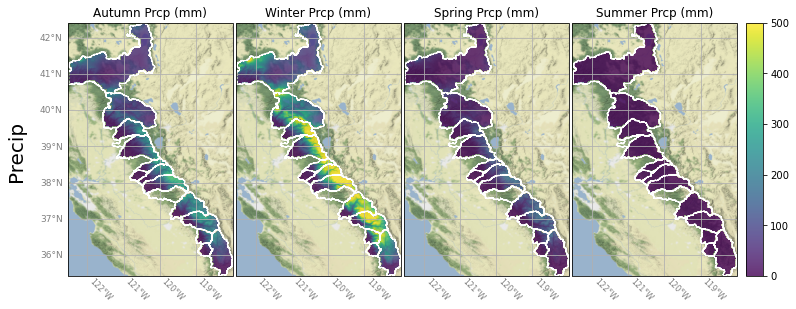

In [11]:
# PRCP SUM

fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(seas_means['prcp_1_sum'], "../shape/sierra_catchments.shp", "Autumn Prcp (mm)", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True, vmax = 500)
plot_basemaps(seas_means['prcp_2_sum'], "../shape/sierra_catchments.shp", "Winter Prcp (mm)", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True, vmax = 500)
plot_basemaps(seas_means['prcp_3_sum'], "../shape/sierra_catchments.shp", "Spring Prcp (mm)", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True, vmax = 500)
plot_basemaps(seas_means['prcp_4_sum'], "../shape/sierra_catchments.shp", "Summer Prcp (mm)", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True, vmax = 500)


# Ylabel
fig.text(.055, 0.5, 'Precip', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()

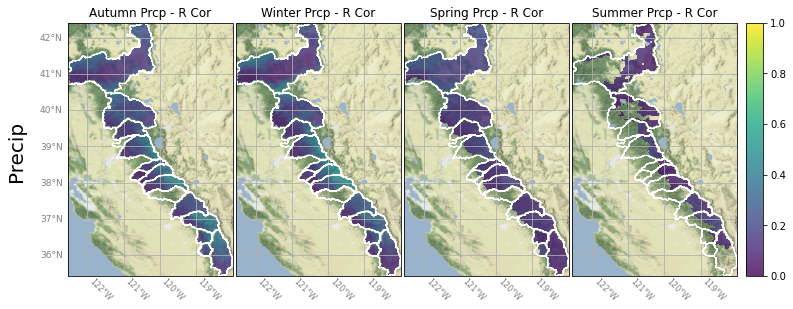

In [12]:
# PRCP COR

fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(seas_means['prcp_1_cor'], "../shape/sierra_catchments.shp", "Autumn Prcp - R Cor", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True, vmax = 1)
plot_basemaps(seas_means['prcp_2_cor'], "../shape/sierra_catchments.shp", "Winter Prcp - R Cor", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True, vmax = 1)
plot_basemaps(seas_means['prcp_3_cor'], "../shape/sierra_catchments.shp", "Spring Prcp - R Cor", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True, vmax = 1)
plot_basemaps(seas_means['prcp_4_cor'], "../shape/sierra_catchments.shp", "Summer Prcp - R Cor", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True, vmax = 1)

# Ylabel
fig.text(.055, 0.5, 'Precip', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()

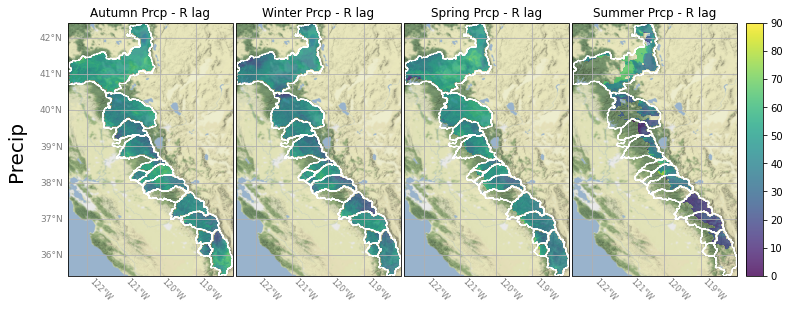

In [13]:
# PRCP LAG

fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(seas_means['prcp_1_lag'], "../shape/sierra_catchments.shp", "Autumn Prcp - R lag", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True, vmax = 90)
plot_basemaps(seas_means['prcp_2_lag'], "../shape/sierra_catchments.shp", "Winter Prcp - R lag", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True, vmax = 90)
plot_basemaps(seas_means['prcp_3_lag'], "../shape/sierra_catchments.shp", "Spring Prcp - R lag", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True, vmax = 90)
plot_basemaps(seas_means['prcp_4_lag'], "../shape/sierra_catchments.shp", "Summer Prcp - R lag", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True, vmax = 90)


# Ylabel
fig.text(.055, 0.5, 'Precip', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()

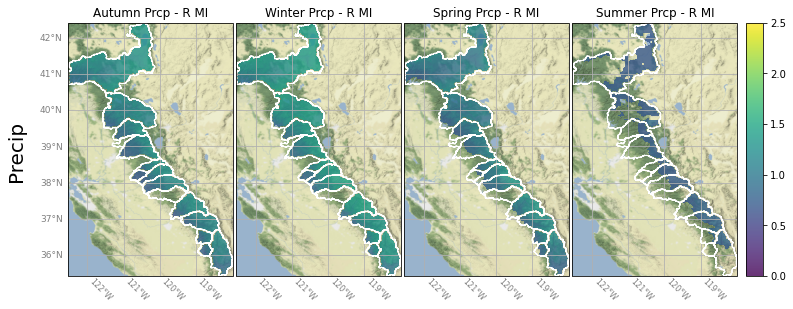

In [14]:
# PRCP MI

fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(seas_means['prcp_1_mi'], "../shape/sierra_catchments.shp", "Autumn Prcp - R MI", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True, vmax = 2.5)
plot_basemaps(seas_means['prcp_2_mi'], "../shape/sierra_catchments.shp", "Winter Prcp - R MI", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True, vmax = 2.5)
plot_basemaps(seas_means['prcp_3_mi'], "../shape/sierra_catchments.shp", "Spring Prcp - R MI", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True, vmax = 2.5)
plot_basemaps(seas_means['prcp_4_mi'], "../shape/sierra_catchments.shp", "Summer Prcp - R MI", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True, vmax = 2.5)


# Ylabel
fig.text(.055, 0.5, 'Precip', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()

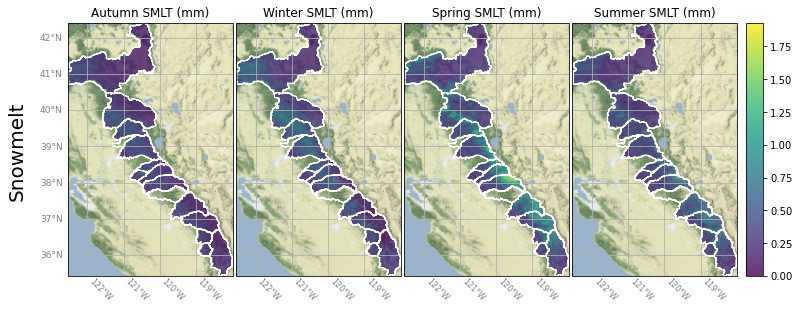

In [15]:
# SMLT SUM

fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(seas_means['smlt_1_sum'], "../shape/sierra_catchments.shp", "Autumn SMLT (mm)", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True, vmax = None)
plot_basemaps(seas_means['smlt_2_sum'], "../shape/sierra_catchments.shp", "Winter SMLT (mm)", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True, vmax = None)
plot_basemaps(seas_means['smlt_3_sum'], "../shape/sierra_catchments.shp", "Spring SMLT (mm)", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True, vmax = None)
plot_basemaps(seas_means['smlt_4_sum'], "../shape/sierra_catchments.shp", "Summer SMLT (mm)", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True, vmax = None)

# Ylabel
fig.text(.055, 0.5, 'Snowmelt', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()

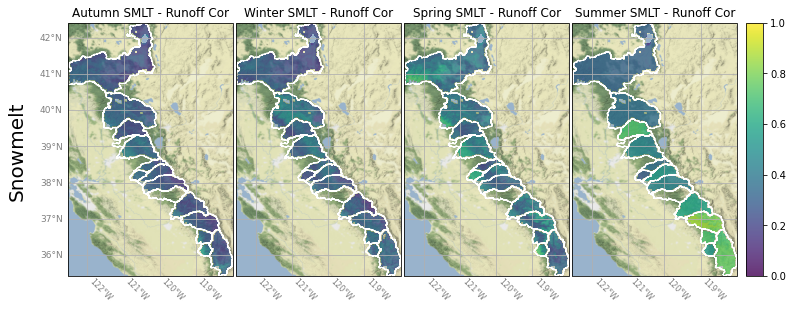

In [16]:
# SMLT COR

fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(seas_means['smlt_1_cor'], "../shape/sierra_catchments.shp", "Autumn SMLT - Runoff Cor", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True, vmax = 1)
plot_basemaps(seas_means['smlt_2_cor'], "../shape/sierra_catchments.shp", "Winter SMLT - Runoff Cor", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True, vmax = 1)
plot_basemaps(seas_means['smlt_3_cor'], "../shape/sierra_catchments.shp", "Spring SMLT - Runoff Cor", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True, vmax = 1)
plot_basemaps(seas_means['smlt_4_cor'], "../shape/sierra_catchments.shp", "Summer SMLT - Runoff Cor", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True, vmax = 1)


# Ylabel
fig.text(.055, 0.5, 'Snowmelt', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()

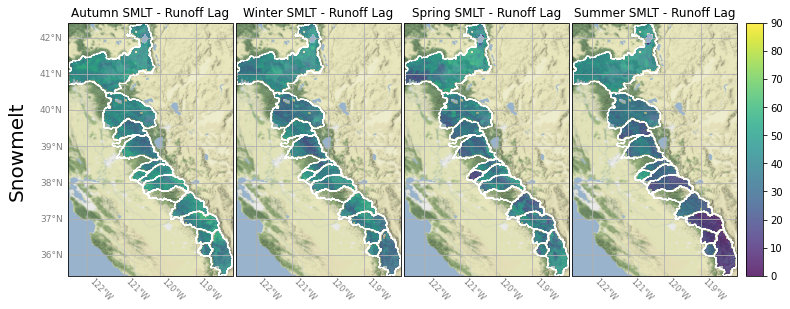

In [17]:
# SMLT LAG 

fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(seas_means['smlt_1_lag'], "../shape/sierra_catchments.shp", "Autumn SMLT - Runoff Lag", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True, vmax = 90)
plot_basemaps(seas_means['smlt_2_lag'], "../shape/sierra_catchments.shp", "Winter SMLT - Runoff Lag", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True, vmax = 90)
plot_basemaps(seas_means['smlt_3_lag'], "../shape/sierra_catchments.shp", "Spring SMLT - Runoff Lag", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True, vmax = 90)
plot_basemaps(seas_means['smlt_4_lag'], "../shape/sierra_catchments.shp", "Summer SMLT - Runoff Lag", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True, vmax = 90)


# Ylabel
fig.text(.055, 0.5, 'Snowmelt', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()

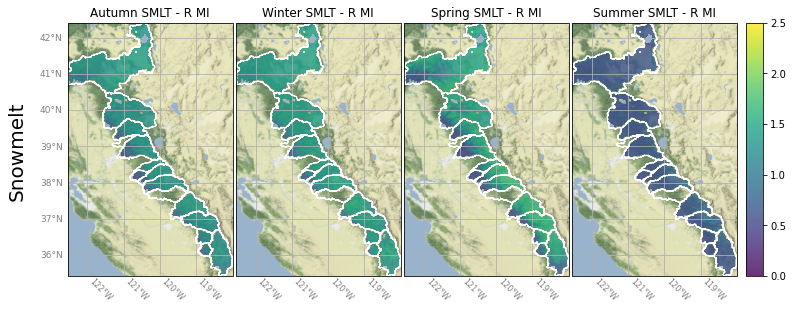

In [18]:
# SMLT MI

fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(seas_means['smlt_1_mi'], "../shape/sierra_catchments.shp", "Autumn SMLT - R MI", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True, vmax = 2.5)
plot_basemaps(seas_means['smlt_2_mi'], "../shape/sierra_catchments.shp", "Winter SMLT - R MI", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True, vmax = 2.5)
plot_basemaps(seas_means['smlt_3_mi'], "../shape/sierra_catchments.shp", "Spring SMLT - R MI", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True, vmax = 2.5)
plot_basemaps(seas_means['smlt_4_mi'], "../shape/sierra_catchments.shp", "Summer SMLT - R MI", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True, vmax = 2.5)

# Ylabel
fig.text(.055, 0.5, 'Snowmelt', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()


# Elevation analysis

* create contours
* plot seasonal means as (f) elev for each contour interval
* To create the contours from a dem: 

```gdal_contour -a 'elev' hu6_srtm_dem.tif ../shape/contours_500m.shp -i 500.0 -p```

<ipython-input-19-e703e3afdb8c>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_under('k', alpha=0)


<AxesSubplot:title={'center':'500m elevation contours '}>

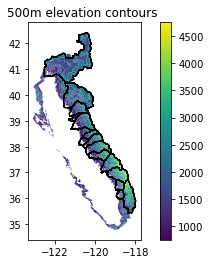

In [19]:
# ELEVATION ANALYSIS 

# Read elevation contours we made 
cont_gdf = gp.read_file("../shape/contours_500m.shp")
cont_gdf['elev'] = np.linspace(250,4750,10) # [int(x) * 500 for x in gdf['ID']] 

# Set alpha val in cmap
cmap = plt.get_cmap('viridis')
cmap.set_under('k', alpha=0)

# plot with watersehds 
ax = cont_gdf.plot(figsize = (7,4), column= 'elev',cmap = cmap, legend = True, vmin = 751)
plt.title('500m elevation contours ')
gp.read_file("../shape/sierra_catchments.shp").plot(ax = ax, facecolor = "none", edgecolor = 'black')

In [20]:
# Define the 500m contour interval 
heights = np.linspace(0,5000,11)
heights = ["{} - {}".format(str(x-500), str(x)) for x in heights]
heights[0] = "<0"

median_hts = np.linspace(250,4750,10)

# Read each contour interval shape
with fiona.open("../shape/contours_500m.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

len(shapes), len(median_hts)


(10, 10)

In [21]:
# Setup dicts to house final results

In [22]:
# Final results dict 
season_res_fin = {}

# Loop thru seasons 
for season in ["1","2","3","4"][:]:
    # setup dict for seasonal results
    seas_var_res = {}

    seas_str = "_" + season + "_"

    for hvar in ['sum','cor','lag','mi'][:]:
        for vartype in ['smlt','prcp'][:]:
            seas_mean_fn = os.path.join(seasonal_mean_dir,vartype+seas_str+hvar+ ".tif")
            print(seas_mean_fn)

            # Set up dict for elevation results
            elev_res = {}

            # Loop through elevation contours
            for idx, shape in enumerate(shapes):
                with rasterio.open(seas_mean_fn) as src:
                    out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                    outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
                    outim[outim==src.nodata]=np.nan #mask nodata vals
                    outim[outim<=0.1] = np.nan
                    elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()

            # Compile summary stats for each elevation bin 
            df_rows = []
            for k,v in elev_res.items():
                varmean = np.nanmean(v)
                varstd = np.nanpercentile(v,66) - np.nanpercentile(v,50)
                var_n = len(~np.isnan(v)) # count non - nan elements 
                sumdf = pd.DataFrame([k,varmean,varstd,var_n]).T
                sumdf.columns = ['elev','{}_mean'.format(vartype+seas_str+hvar),'{}_std'.format(vartype+seas_str+hvar),'{}_num'.format(vartype+seas_str+hvar)]
                df_rows.append(sumdf)

            # Concat the stats we just extracted 
            tdf = pd.concat(df_rows)
            tdf['elev'] = np.linspace(250,4750,10)
            tdf = tdf.astype(float).set_index("elev")

            seas_var_res[vartype+seas_str+hvar] = tdf

    # Concat the seasonal results into one df 
    seasonal_df = pd.concat([v for k,v in seas_var_res.items()], axis = 1)
    season_res_fin[season] = seasonal_df

../results/seasons/seasonal_means/smlt_1_sum.tif


<ipython-input-22-9d3755fd4503>:31: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


../results/seasons/seasonal_means/prcp_1_sum.tif
../results/seasons/seasonal_means/smlt_1_cor.tif
../results/seasons/seasonal_means/prcp_1_cor.tif
../results/seasons/seasonal_means/smlt_1_lag.tif
../results/seasons/seasonal_means/prcp_1_lag.tif
../results/seasons/seasonal_means/smlt_1_mi.tif
../results/seasons/seasonal_means/prcp_1_mi.tif
../results/seasons/seasonal_means/smlt_2_sum.tif
../results/seasons/seasonal_means/prcp_2_sum.tif
../results/seasons/seasonal_means/smlt_2_cor.tif
../results/seasons/seasonal_means/prcp_2_cor.tif
../results/seasons/seasonal_means/smlt_2_lag.tif
../results/seasons/seasonal_means/prcp_2_lag.tif
../results/seasons/seasonal_means/smlt_2_mi.tif
../results/seasons/seasonal_means/prcp_2_mi.tif
../results/seasons/seasonal_means/smlt_3_sum.tif
../results/seasons/seasonal_means/prcp_3_sum.tif
../results/seasons/seasonal_means/smlt_3_cor.tif
../results/seasons/seasonal_means/prcp_3_cor.tif
../results/seasons/seasonal_means/smlt_3_lag.tif
../results/seasons/seaso

In [23]:
# get n pixels as f (elevation) by season

numdfs_prcp = []
numdfs_smlt = []

for season in ['1','2','3','4'][:]:
    sdf = season_res_fin[season]
    
    # Get number of obs for P
    pcols = [x for x in sdf.columns if "prcp" in x and "num" in x and season in x]
    psdf = pd.DataFrame(sdf[pcols].mean(axis = 1))
    psdf.columns = [str(season)]
    numdfs_prcp.append(psdf)

    # Get number of obs for smlt
    scols = [x for x in sdf.columns if "smlt" in x and "num" in x and season in x]
    ssdf = pd.DataFrame(sdf[scols].mean(axis = 1))
    ssdf.columns = [str(season)]
    numdfs_smlt.append(ssdf)
    
# Concat npix into a df
num_smlt = pd.concat(numdfs_smlt, axis = 1)
num_prcp = pd.concat(numdfs_prcp, axis = 1)

masterdf = pd.concat(season_res_fin.values(), axis = 1)

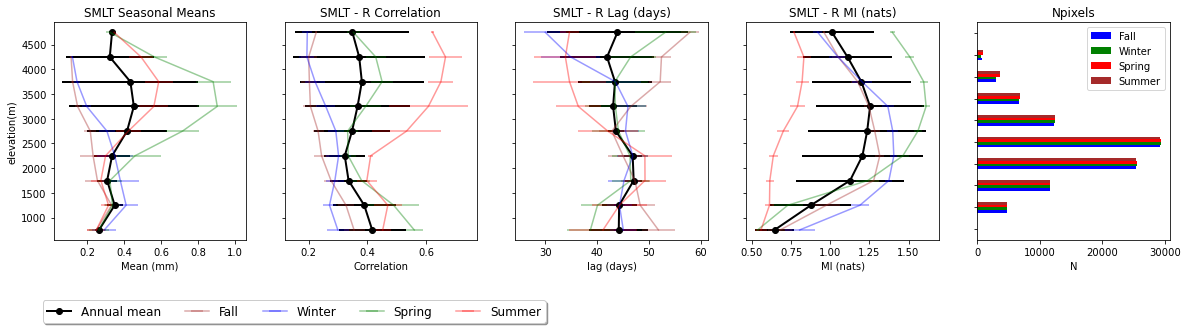

In [24]:
# Plot

# Coppy the master outdict
season_f_smlt = season_res_fin.copy()

# Setup fig
plt.figure(figsize=(20,4))

# Seasonal Means
ax0 = plt.subplot(151)
ax0.set_title("SMLT Seasonal Means")

vartype = 'smlt'
hvar = 'sum'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax0.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax0.errorbar(season_f_smlt['1']['smlt_1_sum_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['1']['smlt_1_sum_std'],label = 'Fall', color = 'brown', alpha = 0.4)
ax0.errorbar(season_f_smlt['2']['smlt_2_sum_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['2']['smlt_2_sum_std'],label = 'Winter', color = 'blue',alpha = 0.4 )
ax0.errorbar(season_f_smlt['3']['smlt_3_sum_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['3']['smlt_3_sum_std'],label = 'Spring', color = 'green',alpha = 0.4 )
ax0.errorbar(season_f_smlt['4']['smlt_4_sum_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['4']['smlt_4_sum_std'],label = 'Summer', color = 'red', alpha = 0.4 )

ax0.set_ylabel("elevation(m)")
ax0.set_xlabel("Mean (mm)")

ax0.legend()
ax0.legend(loc='upper center', bbox_to_anchor=(1.25, -.25), ncol=5, fontsize = 12, fancybox=True, shadow=True)

# Seasonal Correlations
ax1 = plt.subplot(152)
ax1.set_title("SMLT - R Correlation")

vartype = 'smlt'
hvar = 'cor'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax1.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax1.errorbar(season_f_smlt['1']['smlt_1_cor_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['1']['smlt_1_cor_std'],color = 'brown', alpha = 0.4)
ax1.errorbar(season_f_smlt['2']['smlt_2_cor_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['2']['smlt_2_cor_std'], color = 'blue', alpha = 0.4)
ax1.errorbar(season_f_smlt['3']['smlt_3_cor_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['3']['smlt_3_cor_std'], color = 'green', alpha = 0.4 )
ax1.errorbar(season_f_smlt['4']['smlt_4_cor_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['4']['smlt_4_cor_std'], color = 'red', alpha = 0.4)
ax1.set(yticklabels=[])  
ax1.set_xlabel("Correlation")

# Seasonal lagrelations
ax2 = plt.subplot(153)
ax2.set_title("SMLT - R Lag (days)")

vartype = 'smlt'
hvar = 'lag'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax2.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax2.errorbar(season_f_smlt['1']['smlt_1_lag_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['1']['smlt_1_lag_std'],color = 'brown', alpha = 0.4)
ax2.errorbar(season_f_smlt['2']['smlt_2_lag_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['2']['smlt_2_lag_std'], color = 'blue', alpha = 0.4)
ax2.errorbar(season_f_smlt['3']['smlt_3_lag_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['3']['smlt_3_lag_std'], color = 'green', alpha = 0.4 )
ax2.errorbar(season_f_smlt['4']['smlt_4_lag_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['4']['smlt_4_lag_std'], color = 'red', alpha = 0.4)
ax2.set(yticklabels=[])  
ax2.set_xlabel("lag (days)")

# Seasonal MI
ax3 = plt.subplot(154)
ax3.set_title("SMLT - R MI (nats)")

vartype = 'smlt'
hvar = 'mi'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax3.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax3.errorbar(season_f_smlt['1']['smlt_1_mi_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['1']['smlt_1_mi_std'],color = 'brown', alpha = 0.4)
ax3.errorbar(season_f_smlt['2']['smlt_2_mi_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['2']['smlt_2_mi_std'], color = 'blue', alpha = 0.4)
ax3.errorbar(season_f_smlt['3']['smlt_3_mi_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['3']['smlt_3_mi_std'], color = 'green', alpha = 0.4 )
ax3.errorbar(season_f_smlt['4']['smlt_4_mi_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['4']['smlt_4_mi_std'], color = 'red', alpha = 0.4)
ax3.set(yticklabels=[])  
ax3.set_xlabel("MI (nats)")


plt.subplot(155)
num_smlt.columns = ['Fall', "Winter", "Spring", "Summer"]
ax4 = num_smlt.plot(kind = 'barh', ax = plt.gca(),color = ['blue', 'green', 'red', 'brown'])
ax4.set(yticklabels=[])  
ax4.set_ylabel("")  
ax4.set_xlabel("N")  
ax4.set_title("Npixels")
plt.show()

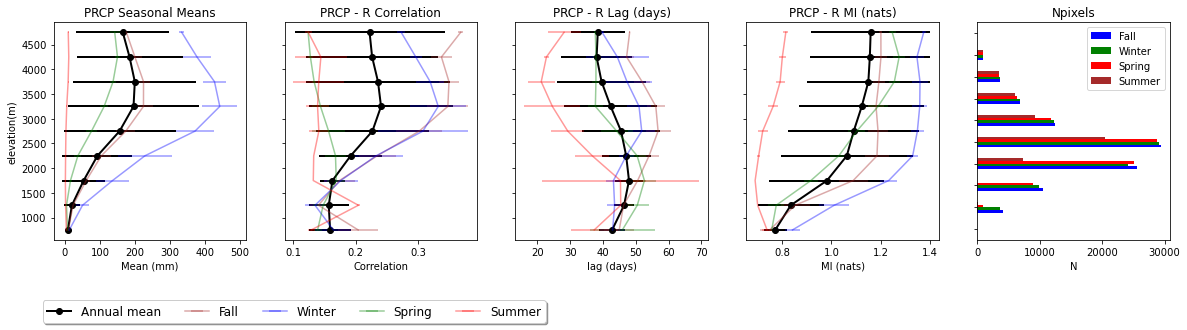

In [25]:
# Coppy the master outdict
season_f_prcp = season_res_fin.copy()

# Setup fig
plt.figure(figsize=(20,4))

# Seasonal Means
ax0 = plt.subplot(151)
ax0.set_title("PRCP Seasonal Means")

vartype = 'prcp'
hvar = 'sum'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax0.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax0.errorbar(season_f_prcp['1']['prcp_1_sum_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['1']['prcp_1_sum_std'],label = 'Fall', color = 'brown', alpha = 0.4)
ax0.errorbar(season_f_prcp['2']['prcp_2_sum_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['2']['prcp_2_sum_std'],label = 'Winter', color = 'blue',alpha = 0.4 )
ax0.errorbar(season_f_prcp['3']['prcp_3_sum_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['3']['prcp_3_sum_std'],label = 'Spring', color = 'green',alpha = 0.4 )
ax0.errorbar(season_f_prcp['4']['prcp_4_sum_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['4']['prcp_4_sum_std'],label = 'Summer', color = 'red', alpha = 0.4 )

ax0.set_ylabel("elevation(m)")
ax0.set_xlabel("Mean (mm)")

ax0.legend()
ax0.legend(loc='upper center', bbox_to_anchor=(1.25, -.25), ncol=5, fontsize = 12, fancybox=True, shadow=True)

# Seasonal Correlations
ax1 = plt.subplot(152)
ax1.set_title("PRCP - R Correlation")

vartype = 'prcp'
hvar = 'cor'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax1.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax1.errorbar(season_f_prcp['1']['prcp_1_cor_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['1']['prcp_1_cor_std'],color = 'brown', alpha = 0.4)
ax1.errorbar(season_f_prcp['2']['prcp_2_cor_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['2']['prcp_2_cor_std'], color = 'blue', alpha = 0.4)
ax1.errorbar(season_f_prcp['3']['prcp_3_cor_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['3']['prcp_3_cor_std'], color = 'green', alpha = 0.4 )
ax1.errorbar(season_f_prcp['4']['prcp_4_cor_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['4']['prcp_4_cor_std'], color = 'red', alpha = 0.4)
ax1.set(yticklabels=[])  
ax1.set_xlabel("Correlation")

# Seasonal lagrelations
ax2 = plt.subplot(153)
ax2.set_title("PRCP - R Lag (days)")

vartype = 'prcp'
hvar = 'lag'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax2.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax2.errorbar(season_f_prcp['1']['prcp_1_lag_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['1']['prcp_1_lag_std'],color = 'brown', alpha = 0.4)
ax2.errorbar(season_f_prcp['2']['prcp_2_lag_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['2']['prcp_2_lag_std'], color = 'blue', alpha = 0.4)
ax2.errorbar(season_f_prcp['3']['prcp_3_lag_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['3']['prcp_3_lag_std'], color = 'green', alpha = 0.4 )
ax2.errorbar(season_f_prcp['4']['prcp_4_lag_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['4']['prcp_4_lag_std'], color = 'red', alpha = 0.4)
ax2.set(yticklabels=[])  
ax2.set_xlabel("lag (days)")

# Seasonal MI
ax3 = plt.subplot(154)
ax3.set_title("PRCP - R MI (nats)")

vartype = 'prcp'
hvar = 'mi'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax3.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax3.errorbar(season_f_prcp['1']['prcp_1_mi_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['1']['prcp_1_mi_std'],color = 'brown', alpha = 0.4)
ax3.errorbar(season_f_prcp['2']['prcp_2_mi_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['2']['prcp_2_mi_std'], color = 'blue', alpha = 0.4)
ax3.errorbar(season_f_prcp['3']['prcp_3_mi_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['3']['prcp_3_mi_std'], color = 'green', alpha = 0.4 )
ax3.errorbar(season_f_prcp['4']['prcp_4_mi_mean'], season_f_prcp['1'].index, xerr =season_f_prcp['4']['prcp_4_mi_std'], color = 'red', alpha = 0.4)
ax3.set(yticklabels=[])  
ax3.set_xlabel("MI (nats)")


plt.subplot(155)
num_prcp.columns = ['Fall', "Winter", "Spring", "Summer"]
ax4 = num_prcp.plot(kind = 'barh', ax = plt.gca(),color = ['blue', 'green', 'red', 'brown'])
ax4.set(yticklabels=[])  
ax4.set_ylabel("")  
ax4.set_xlabel("N")  
ax4.set_title("Npixels")
plt.show()

In [26]:
# Plot full time series for each variable

seas_month_lookup = {"1":"1", "2":"3", "3": "6", "4":"9"}

full_ts_df = []
for vartype in ['smlt','prcp'][:]:
    
    for hvar in tqdm(['sum','cor','lag','mi'][:]):   

        # setup results dict
        var_ts = {}
        
        match_str = vartype + "_" + hvar + "_"
        
        # Find the files and sort
        all_var_files = [os.path.join(outdir,x) for x in os.listdir(outdir) if match_str in x]
        sorted_var_files = {x[-9:-5]+ "-" + seas_month_lookup[x[-11:-10]]:x for x in all_var_files}
        date_strs = [x[-9:-5]+ "-" + seas_month_lookup[x[-11:-10]] for x in all_var_files]
        
        # Still sorting 
        date_strs.sort()
        all_var_files.sort()
        
        # Finally sorted
        ts_arrs = []
        for date in date_strs:
            src = rio.open(sorted_var_files[date])
            arr = src.read(1)
            arr[arr==src.nodata] = np.nan
            if vartype == "smlt" and hvar =='sum':
                var_ts[date] = np.nansum(arr)/ len(~np.isnan(arr))
            else:
                var_ts[date] = np.nanmean(arr)
            
        tsdf = pd.DataFrame(list(var_ts.values()))
        tsdf.index = pd.to_datetime(list(var_ts.keys()))
        tsdf.columns = [vartype + "_" + hvar]
    
        full_ts_df.append(tsdf)

100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


In [27]:
tsvardf = pd.concat(full_ts_df, axis = 1)

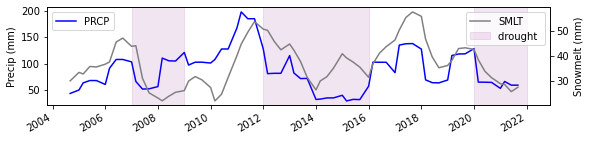

In [28]:
ax = tsvardf['prcp_sum'].rolling(4).mean().plot(color = 'blue', label = "PRCP", figsize = (9,2))
ax.set_ylabel("Precip (mm)")
ax2 = ax.twinx()
tsvardf['smlt_sum'].rolling(4).mean().plot(ax = ax2, color = 'gray', label = "SMLT")

ax.legend(loc = 'upper left')
plt.axvspan('2007-01-01', '2009-01-01', alpha=0.1, color='purple', label = 'drought ')
plt.axvspan('2012-01-01', '2016-01-01', alpha=0.1, color='purple')
plt.axvspan('2020-01-01', '2022-01-01', alpha=0.1, color='purple')
ax2.legend(loc = 'upper right')
ax2.set_ylabel("Snowmelt (mm)")
plt.show()

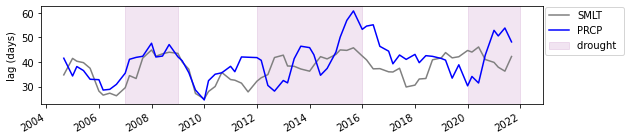

In [29]:
ax = tsvardf['smlt_lag'].rolling(4).mean().plot(color = 'gray', label = "SMLT", figsize = (9,2))
tsvardf['prcp_lag'].rolling(4).mean().plot(ax = ax, color = 'blue', label = "PRCP")
ax.set_ylabel("lag (days)")
# Shade droughts 
plt.axvspan('2007-01-01', '2009-01-01', alpha=0.1, color='purple', label = 'drought ')
plt.axvspan('2012-01-01', '2016-01-01', alpha=0.1, color='purple')
plt.axvspan('2020-01-01', '2022-01-01', alpha=0.1, color='purple')
ax.legend(loc = 'upper right', bbox_to_anchor = (1.17,1.05))
plt.show()

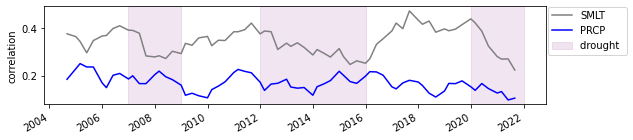

In [30]:
ax = tsvardf['smlt_cor'].rolling(4).mean().plot(color = 'gray', label = "SMLT", figsize = (9,2))
tsvardf['prcp_cor'].rolling(4).mean().plot(color = 'blue', label = "PRCP")
ax.set_ylabel("correlation")
# Shade droughts 
plt.axvspan('2007-01-01', '2009-01-01', alpha=0.1, color='purple', label = 'drought ')
plt.axvspan('2012-01-01', '2016-01-01', alpha=0.1, color='purple')
plt.axvspan('2020-01-01', '2022-01-01', alpha=0.1, color='purple')
ax.legend(loc = 'upper right', bbox_to_anchor = (1.17,1.05))
plt.show()

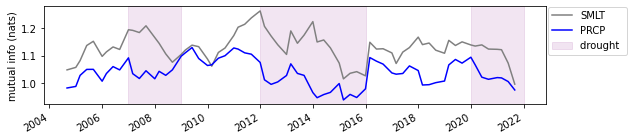

In [31]:
ax = tsvardf['smlt_mi'].rolling(4).mean().plot(color = 'gray', label = "SMLT", figsize = (9,2))
tsvardf['prcp_mi'].rolling(4).mean().plot(color = 'blue', label = "PRCP")
ax.set_ylabel("mutual info (nats)")
# Shade droughts 
plt.axvspan('2007-01-01', '2009-01-01', alpha=0.1, color='purple', label = 'drought ')
plt.axvspan('2012-01-01', '2016-01-01', alpha=0.1, color='purple')
plt.axvspan('2020-01-01', '2022-01-01', alpha=0.1, color='purple')
ax.legend(loc = 'upper right', bbox_to_anchor = (1.17,1.05))

plt.show()